# Parameterizing Vertical Mixing Coefficients in the Ocean Surface Boundary Layer Using Neural Networks


In this notebook, we reproduce some of the analysis carried out in ** Sane et al. (2023) "Parameterizing vertical mixing coefficients in the ocean surface boundary layer using neural networks."** *Journal of Advances in Modeling Earth Systems* 15.10: e2023MS003890

This notebook provides a set of starter codes for **parameterizing vertical mixing in the ocean surface boundary layer using machine learning techniques.**

### Tasks Covered:
- **Data Processing and Preparation**: Reading and filtering the Generalized Ocean Turbulence Model (GOTM) output.
- **Neural Network Training**: Implementing neural networks to predict shape function $ g(\sigma) $ based on input physical parameters.
- **Hyperparameter Optimization**: Conducting a hyperparameter sweep to evaluate the effect of different model architectures (e.g., number of layers, nodes) on performance.
- **Model Evaluation and Visualization**: Analyzing the model's skill using metrics like training/validation loss, and visualizing results.

 
### Collaboration Guidelines
- GitHub sharing is recommended. 
  - We have prepared a [Github Tutorial](https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges/blob/main/Tutorials/Github-Tutorial.md) to help. 
  - If this is not working for you, please reach out with questions.

# 1. Setup workspace and Import packages

In [1]:
%%capture
import importlib

# Check and install torch
if importlib.util.find_spec("torch") is None:
    !pip install torch

# Check and install zarr
if importlib.util.find_spec("zarr") is None:
    !pip install zarr

# Ensure xarray is upgraded
!pip install --upgrade xarray


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import copy as copy
import matplotlib as mpl
import netCDF4 as ncd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from torch import nn, optim
import matplotlib.cm as cm
import copy as copy
import multiprocessing as mp
from scipy import stats
import time as time
import matplotlib.font_manager
import seaborn as sns
import pandas as pd
from tqdm import tqdm  # Import tqdm for the progress bar
import xarray as xr
import requests

from datetime import datetime
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

today = datetime.today()
torch.cuda.empty_cache()

cwd=os.getcwd()
parent_dir = os.path.dirname(cwd)
os.chdir(parent_dir)
cwd = parent_dir
print("Current working directory:", os.getcwd())

# custom modules
import lib.func_file as ff
from lib.visual_figure4 import performance_sigma_point
from lib.visual_figure3 import score_eval, save_losses_by_seed, plot_n1_scores

np.random.seed(100)

cwd_data = cwd + '/data/'
## 
cwd_output = cwd + '/output/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Current working directory: /home/jovyan/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization


# 2. Introduction


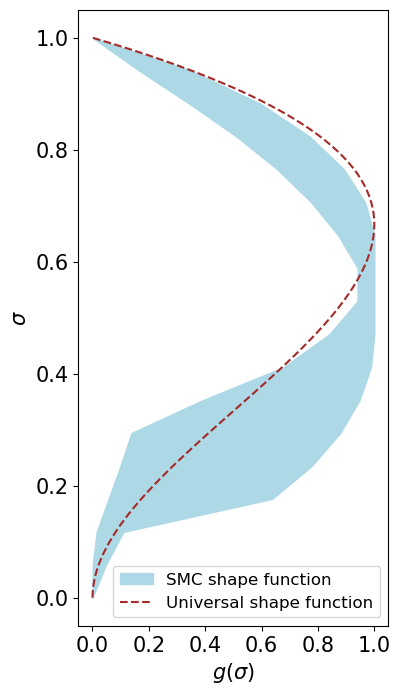

In [3]:
# d=ncd.Dataset(cwd_data+'training_data_raw_time_index_49_149.nc').variables

store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/raw_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

h=d['h'][:]
h_ind1=np.where(h>10)[0]
h_ind2=np.where(h<700)[0]
h_ind=np.intersect1d(h_ind1,h_ind2)
sf1=d['SF'][h_ind,:]
sf1=sf1[237945:237945+5000,:] # randomly selected few profiles.

sf=np.zeros([len(sf1),16])

# for i in range(len(sf1)):
#     sf[i,:]=sf1[i,:]/np.max(sf1[i,:])

sf1 = sf1.values if hasattr(sf1, "values") else sf1
sf = sf1 / np.max(sf1, axis=1, keepdims=True)
    
sig=np.linspace(0,1,18)
z=np.linspace(0,1,100)
z1=z*(1-z)**2
z1=z1/np.max(z1)

sfmin=np.zeros(18)
sfmax=np.zeros(18)
sfmin[1:17]=np.min(sf,axis=0)
sfmax[1:17]=np.max(sf,axis=0)

plt.figure(figsize=(4,8))
#plt.plot(sfmin,sig,'o')
#plt.plot(sfmax,sig,'o')
plt.fill_betweenx(sig,sfmin,sfmax,color='lightblue',label='SMC shape function')
plt.plot(z1[::-1],z,color='brown',linestyle='--',label='Universal shape function')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$g(\sigma)$',fontsize=15)
plt.ylabel(r'$\sigma$',fontsize=15)
plt.legend(fontsize=12)


Vertical mixing in the ocean surface boundary layer (OSBL) plays a vital role in regulating the exchange of heat, momentum, and nutrients between the atmosphere and the deeper ocean. These processes directly influence the ocean component of global climate models (GCMs) and ocean general circulation models (OGCMs), making accurate parameterization of vertical diffusivity $ \kappa_\phi $ a critical component of ocean modeling.

Traditionally, vertical diffusivity is parameterized using **universal shape functions**, such as the dashed line shown in the figure. These fixed, predefined profiles assume uniformity across diverse ocean conditions. However, as illustrated in Figure 1, shape functions derived from second moment closure (SMC) methods (blue shaded region) demonstrate significant variability under different forcing conditions. The discrepancy between the universal shape function and SMC-derived profiles highlights a fundamental limitation: universal functions fail to capture the dynamic, environment-dependent behavior of vertical mixing.

This deficiency motivates the need for a more adaptive and accurate approach. Sane et al. (2023) propose a **neural network-based model** to replace the universal shape function. Neural networks offer the flexibility to learn complex, nonlinear relationships from data and can dynamically adjust the shape function to reflect varying physical conditions. This data-driven, physics-aware method not only improves vertical diffusivity predictions but also bridges the gap between traditional parameterization schemes and the variability observed in high-fidelity SMC models.

The approach integrates two neural networks:

1. $ \mathcal{N}_1 $: Predicts the shape function $ g(\sigma) $, capturing the vertical structure of diffusivity.
2. $ \mathcal{N}_2 $: Predicts the velocity scale $ v_0 $, which, combined with $ g(\sigma) $, yields the full diffusivity profile.

By leveraging neural networks, the authors aim to enhance the accuracy and generalizability of vertical mixing parameterizations in OGCMs, enabling more reliable climate predictions.

In the Climate Prediction Challenges course at Columbia University in Spring 2025, we will focus on predicting the vertical diffusivity shape function  $ g(\sigma) $ using the neural network  $ \mathcal{N}_1 $.

# 2. Data 

## 2.1 Dataset Description

### Overview of Data Generation
The training data for $ \mathcal{N}_1 $ is derived from outputs of the **General Ocean Turbulence Model (GOTM)**. GOTM is a one-dimensional water column model designed for simulating vertical turbulent mixing processes in the ocean. It provides a flexible and modular framework for testing turbulence parameterizations and studying oceanic boundary layer dynamics. GOTM is widely used in oceanography and climate research to investigate turbulence fluxes and vertical diffusivity.

For more information, documentation, and source code, visit the official GOTM website: [GOTM Homepage](https://gotm.net)


While GOTM does not explicitly use a predefined shape function, its outputs are rich enough to derive one. Specifically, the shape function $ g(\sigma) $ used in our project is constructed by normalizing the vertical diffusivity profile ($ \kappa_\phi $).

---

In this project, we do not focus on the simulation phase but directly use pre-processed data provided in the form of NetCDF files. This dataset contains all necessary variables for training $ \mathcal{N}_1 $, eliminating the need to run GOTM simulations.

The dataset includes the following variables:

- **l0 (Coriolis Force)**: Coriolis parameter, calculated based on latitude.
- **b0 (Surface Buoyancy Flux)**: Represents buoyancy flux at the surface.
- **ustar0 (Surface Friction Velocity)**: Surface friction velocity, related to wind shear.
- **h0 (Boundary Layer Depth)**: The depth of the boundary layer in the ocean or atmosphere.
- **lat0 (Latitude)**: Geographical latitude in degrees.
- **heat0 (Surface Heat Flux)**: Heat flux at the surface, measured in W/m².
- **tx0 (Wind Stress)**: Surface wind stress, measured in N/m².
- **Shape Function ($ \text{SF} $)**: The normalized diffusivity profile ($ g(\sigma) $).


In [4]:
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/sf_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

# d=ncd.Dataset(cwd_data+'training_data_for_SF_hbl_gaps_filled.nc').variables

def corio(lat):
    return  2*(2*np.pi/(24*60*60)) * np.sin(lat*(np.pi/180))

l0=corio(d['l'][:])
b00=d['b0'][:]
ustar0=d['ustar'][:]
h0=d['h'][:]
lat0=d['lat'][:]
heat0=d['heat'][:]
tx0=d['tx'][:] 
tx0=np.round(tx0,2)
SF0=d['SF'][:] 


## 2.2 Visualization

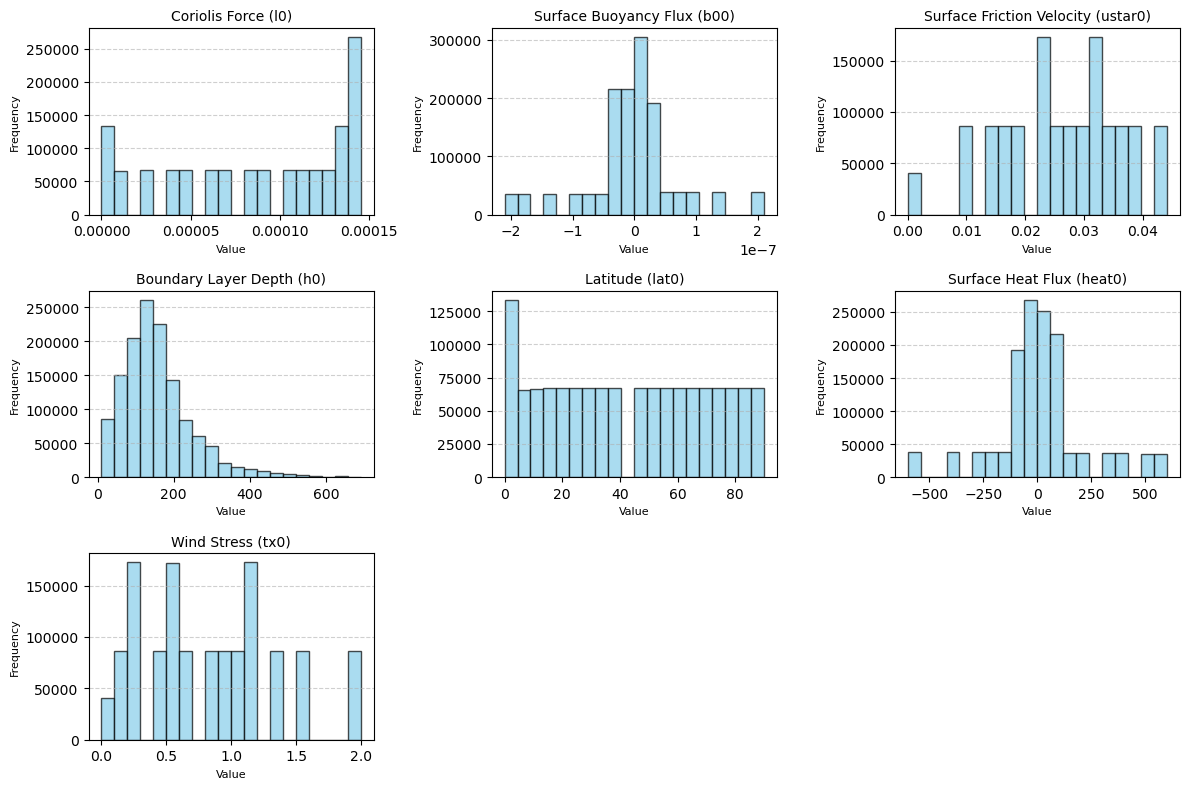

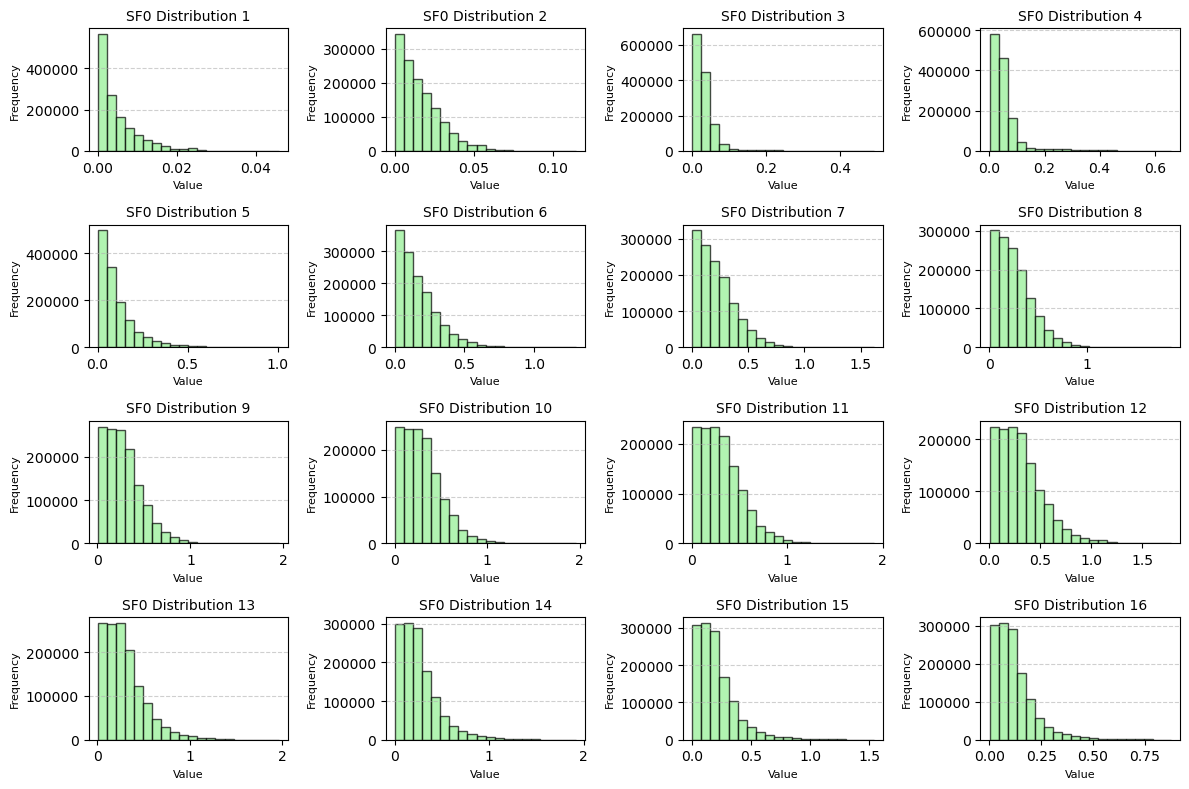

In [5]:
variables = {
    "Coriolis Force (l0)": l0.values.flatten(),
    "Surface Buoyancy Flux (b00)": b00.values.flatten(),
    "Surface Friction Velocity (ustar0)": ustar0.values.flatten(),
    "Boundary Layer Depth (h0)": h0.values.flatten(),
    "Latitude (lat0)": lat0.values.flatten(),
    "Surface Heat Flux (heat0)": heat0.values.flatten(),
    "Wind Stress (tx0)": tx0.values.flatten(),
}

# Plot histograms for the variables
plt.figure(figsize=(12, 8))
for i, (name, data) in enumerate(variables.items()):
    plt.subplot(3, 3, i + 1)
    plt.hist(data, bins=20, color="skyblue", edgecolor="black", alpha=0.7)
    plt.title(name, fontsize=10)
    plt.xlabel("Value", fontsize=8)
    plt.ylabel("Frequency", fontsize=8)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Plot histograms for SF0 distributions
plt.figure(figsize=(12, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.hist(SF0[:, i].values.flatten(), bins=20, color="lightgreen", edgecolor="black", alpha=0.7)
    plt.title(f"SF0 Distribution {i + 1}", fontsize=10)
    plt.xlabel("Value", fontsize=8)
    plt.ylabel("Frequency", fontsize=8)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


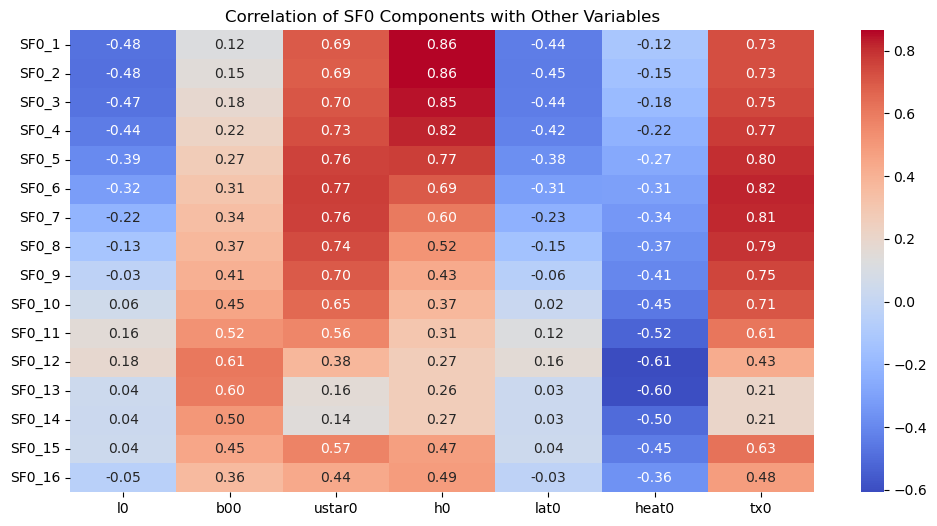

In [6]:
data = {
    "l0": l0.values.flatten(),
    "b00": b00.values.flatten(),
    "ustar0": ustar0.values.flatten(),
    "h0": h0.values.flatten(),
    "lat0": lat0.values.flatten(),
    "heat0": heat0.values.flatten(),
    "tx0": tx0.values.flatten(),
}

for i in range(16):
    data[f"SF0_{i+1}"] = SF0[:, 16-i-1].values.flatten()


df = pd.DataFrame(data)

correlation_matrix = df.corr()

sf0_correlation = correlation_matrix.loc["SF0_1":"SF0_16", ["l0", "b00", "ustar0", "h0", "lat0", "heat0", "tx0"]]

plt.figure(figsize=(12, 6))
sns.heatmap(sf0_correlation, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation of SF0 Components with Other Variables")
plt.show()


The correlation between SF0 components and other variables is expected to exhibit a smooth transition with increasing depth, where deeper layers typically show weaker correlations due to the diminishing influence of surface dynamics. However, between nodes 8 and 15, there is an abrupt shift, suggesting the presence of distinct dynamics or influencing factors in this depth range.



## 2.3 Data Filtering
To ensure high-quality and valid data for training, specific filtering criteria are applied by Sane et al. (2023):

1. Heat flux ($ \text{heat} $) magnitude below 601 $ W/m^2 $.
2. Wind stress ($ \text{tx} $) below 1.2 $ N/m^2 $.
3. Boundary layer depth ($ \text{h} $) between 30 m and 300 m.

In [7]:
ind101=np.where(np.abs(heat0)<601)[0]
ind1=ind101 
ind2=np.where(tx0<1.2)[0]
ind3=np.where(h0>29)[0]
ind4=np.where(h0<301)[0]

ind5=np.intersect1d(ind1,ind2)
ind6=np.intersect1d(ind3,ind5)
ind7=np.intersect1d(ind4,ind6)

In [8]:
mm1=0; mm2=16  #0; 16
data_load_main=np.zeros([len(h0[ind7]),4+mm2-mm1])
data_load_main[:,0]=l0[ind7]
data_load_main[:,1]=b00[ind7]
data_load_main[:,2]=ustar0[ind7]
data_load_main[:,3]=h0[ind7]
data_load_main[:,4:(mm2-mm1+4)]=SF0[ind7,mm1:mm2]

data_forc=np.zeros([len(ind7),3])
data_forc[:,0]=lat0[ind7]
data_forc[:,1]=heat0[ind7]
data_forc[:,2]=tx0[ind7]

data_load3=copy.deepcopy(data_load_main)

print('started')

data, x,y, stats, k_mean, k_std=ff.preprocess_train_data(data_load3)


started


## 2.4 Validation Dataset

In this project, training and validation datasets are generated independently through separate simulations. This practice ensures **strict independence** between the two datasets, avoiding issues like **data leakage** or overfitting. 

In [9]:
# valid_data=np.loadtxt(cwd_data+'data_testing_4_paper.txt')[:,3:]

url = "https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/data_testing_4_paper.txt"
valid_data = np.loadtxt(url, delimiter=None)[:,3:] 

ind3=np.where(valid_data[:,3]>29)[0]
ind4=np.where(valid_data[:,3]<301)[0]
ind=np.intersect1d(ind3,ind4)

valid_x=valid_data[ind,0:4]

valid_x[:,0]=(valid_x[:,0]-stats[0])/stats[1]
valid_x[:,1]=(valid_x[:,1]-stats[2])/stats[3]
valid_x[:,2]=(valid_x[:,2]-stats[4])/stats[5]
valid_x[:,3]=(valid_x[:,3]-stats[6])/stats[7]
k_mean_test=np.zeros(16)
valid_y=valid_data[ind,5:]

for i in range(len(valid_y)):
    valid_y[i,:]=np.log(valid_y[i,:]/np.max(valid_y[i,:]))

for i in range(16):
    valid_y[:,i]=(valid_y[:,i]-k_mean[i])/k_std[i]

In [10]:
x=torch.FloatTensor(x).to(device)
y=torch.FloatTensor(y).to(device)

valid_x=torch.FloatTensor(valid_x).to(device)
valid_y=torch.FloatTensor(valid_y).to(device)

# 3. Neural Network Architecture

The learnKappa_layers class is a neural network model built using PyTorch's nn.Module. It consists of three fully connected (linear) layers with ReLU activation and dropout for regularization. 

In [11]:
class learnKappa_layers(nn.Module):
    def __init__(self, In_nodes, Hid, Out_nodes):
        super(learnKappa_layers, self).__init__()
        self.linear1 = nn.Linear(In_nodes, Hid)  # First layer: Input to hidden
        self.linear2 = nn.Linear(Hid, Hid)       # Second layer: Hidden to hidden
        self.linear3 = nn.Linear(Hid, Out_nodes) # Third layer: Hidden to output
        self.dropout = nn.Dropout(0.25)          # Dropout for regularization

    def forward(self, x):
        x2 = self.linear1(x)
        h1 = torch.relu(x2)            # ReLU activation for layer 1
        h1 = self.dropout(h1)          # Apply dropout
        
        h2 = self.linear2(h1)
        h3 = torch.relu(h2)            # ReLU activation for layer 2
        h3 = self.dropout(h3)          # Apply dropout

        y_pred = self.linear3(h3)      # Final output layer
        return y_pred


# 4. Model Training

The modeltrain_loss function trains a neural network model using PyTorch with a custom loss calculation and implements early stopping to prevent overfitting.

Early Stopping: Stops training if the validation loss does not improve for patience consecutive epochs, saving the best model state.

In [12]:
def modeltrain_loss(In_nodes, Hid, Out_nodes, lr, epochs, x, y, valid_x, valid_y, model, k_std_y, k_mean, k_std, patience=10):
    optimizer = torch.optim.Adam(model.parameters(), lr)  # Adam optimizer
    loss_fn = torch.nn.L1Loss(reduction='mean')  # L1 loss for gradient computation
    loss_array = torch.zeros([epochs, 3])  # Array to store epoch, train, and validation losses

    best_loss = float('inf')  # Initialize the best validation loss as infinity
    no_improvement = 0  # Counter for epochs without improvement
    best_model_state = None  # Placeholder for the best model state

    # Add a progress bar
    with tqdm(total=epochs, desc="Training Progress", unit="epoch") as pbar:
        for k in range(epochs):
            optimizer.zero_grad()  # Clear gradients from the previous step
            y_pred = model(x)  # Forward pass for training data
            
            valid_pred = model(valid_x)  # Forward pass for validation data
            
            # Loss used for gradient calculation
            loss = loss_fn(y_pred * k_std_y, y * k_std_y)
            
            loss_train = torch.mean(torch.abs(torch.exp(y_pred * k_std + k_mean) - torch.exp(y * k_std + k_mean)))
            loss_valid = torch.mean(torch.abs(torch.exp(valid_pred * k_std + k_mean) - torch.exp(valid_y * k_std + k_mean)))
            
            loss.backward()  # Backpropagate the gradient
            optimizer.step()  # Update model parameters

            # Record the losses for this epoch
            loss_array[k, 0] = k  
            loss_array[k, 1] = loss_train.item()  
            loss_array[k, 2] = loss_valid.item()  

            # Update the progress bar with the current epoch and losses
            pbar.set_postfix(
                train_loss=loss_train.item(), 
                valid_loss=loss_valid.item(), 
                patience_count=no_improvement
            )
            pbar.update(1)  # Increment the progress bar

            # Early stopping: Check if validation loss improves
            if loss_valid.item() < best_loss:
                best_loss = loss_valid.item()  # Update best loss
                no_improvement = 0
                best_model_state = model.state_dict()  
            else:
                no_improvement += 1  # Increment no improvement counter

            # If no improvement for 'patience' epochs, stop training
            if no_improvement >= patience:
                print(f"\nEarly stopping at epoch {k+1}. Validation loss has not improved for {patience} epochs.")
                break

            # Free memory by deleting intermediate variables
            del loss, y_pred
            
    # Restore the best model state after training
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, loss_array[:k, :]


In [13]:
epochs, k_points, lr=3000, 16, 1e-03

kms1=1.0 #0.1
kms2=1.0 #100.0
kmask=np.array([kms1,kms1,kms2,kms2,kms2,kms2,kms2,kms2,kms2,kms1,kms1,kms1,kms1,kms1,kms1,kms1])

in_nod, hid_nod, o_nod = 4, 32, 16

torch.manual_seed(10)

k_mean_c=torch.tensor(k_mean).float().to(device)
k_std_c=torch.tensor(k_std).float().to(device)

model = learnKappa_layers(in_nod, hid_nod, o_nod)
model = model.to(device)
model, loss_array = modeltrain_loss(in_nod, hid_nod, o_nod, lr, epochs, x, y,valid_x,valid_y,model,torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)


Training Progress:  19%|█▉        | 564/3000 [00:18<01:21, 29.82epoch/s, patience_count=9, train_loss=0.0403, valid_loss=0.0574]



Early stopping at epoch 564. Validation loss has not improved for 10 epochs.


# 5. Evaluation and Visualization

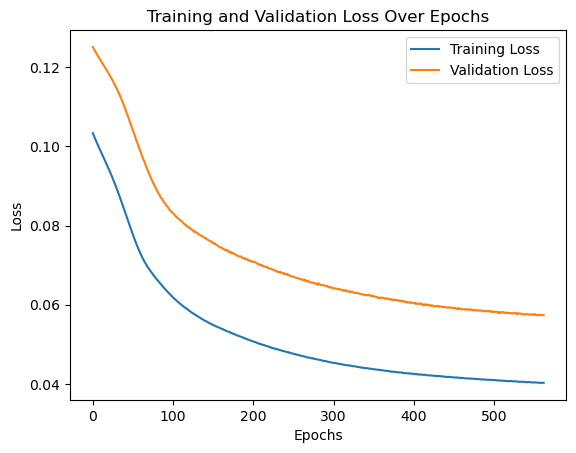

In [14]:
plt.plot(loss_array[:, 0], loss_array[:, 1], label="Training Loss")
plt.plot(loss_array[:, 0], loss_array[:, 2], label="Validation Loss")

# Adding labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()


Plot saved as 'modelstats.pdf'


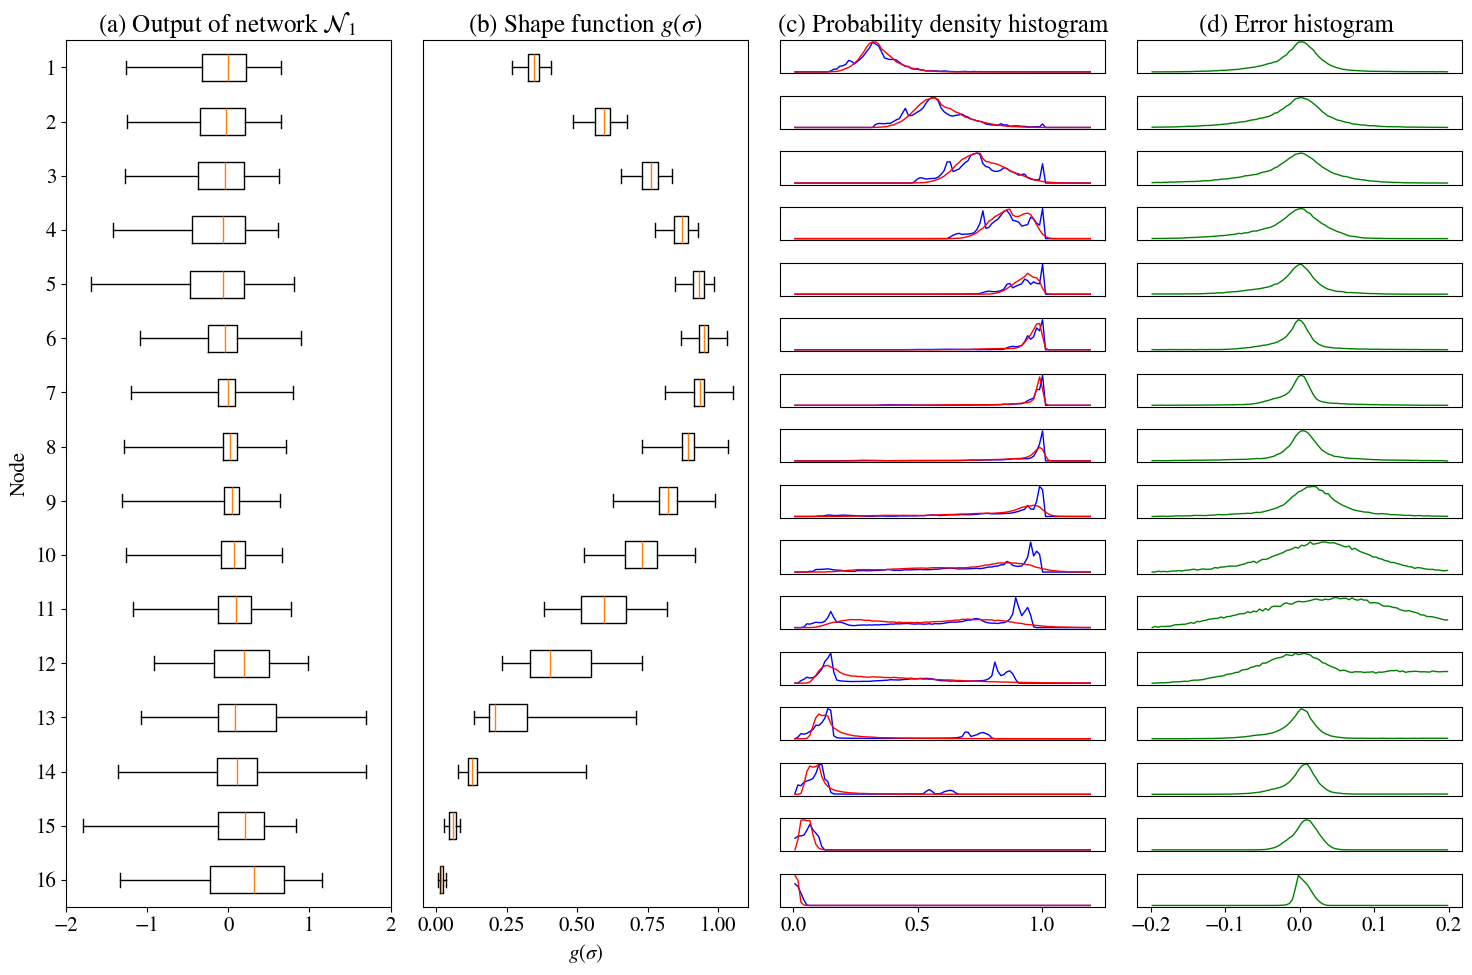

In [15]:
performance_sigma_point(model, x, valid_x, y, valid_y, k_mean, k_std)

# 6. Further Exploration

## 6.1 Tweaking Loss Function with Node-Specific Weighting

In this exploration, we adjusted the training process by modifying the loss function to prioritize nodes with higher variance. Key steps and configurations:

**Node-Specific Weighting**: We applied node-specific weights (`kmask`) to amplify the loss values for nodes 8 to 13 by a factor of 100 (`kms2 = 100.0`), while keeping the weight at other nodes as 1.0 (`kms1 = 1.0`).

This approach helps focus the model on reducing errors for nodes with higher variance, making them easier to learn.

In [16]:
epochs, k_points, lr=3000, 16, 1e-03

kms1=1.0 #0.1
kms2=100.0 #1000.0
kmask=np.array([kms1,kms1,kms2,kms2,kms2,kms2,kms2,kms2,kms2,kms1,kms1,kms1,kms1,kms1,kms1,kms1])

in_nod, hid_nod, o_nod = 4, 32, 16

torch.manual_seed(10)

k_mean_c=torch.tensor(k_mean).float().to(device)
k_std_c=torch.tensor(k_std).float().to(device)

model = learnKappa_layers(in_nod, hid_nod, o_nod)
model = model.to(device)
model, loss_array = modeltrain_loss(in_nod, hid_nod, o_nod, lr, epochs, x, y,valid_x,valid_y,model,torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)


Training Progress:  21%|██        | 631/3000 [00:21<01:19, 29.96epoch/s, patience_count=9, train_loss=0.0405, valid_loss=0.0594]


Early stopping at epoch 631. Validation loss has not improved for 10 epochs.


Plot saved as 'modelstats.pdf'


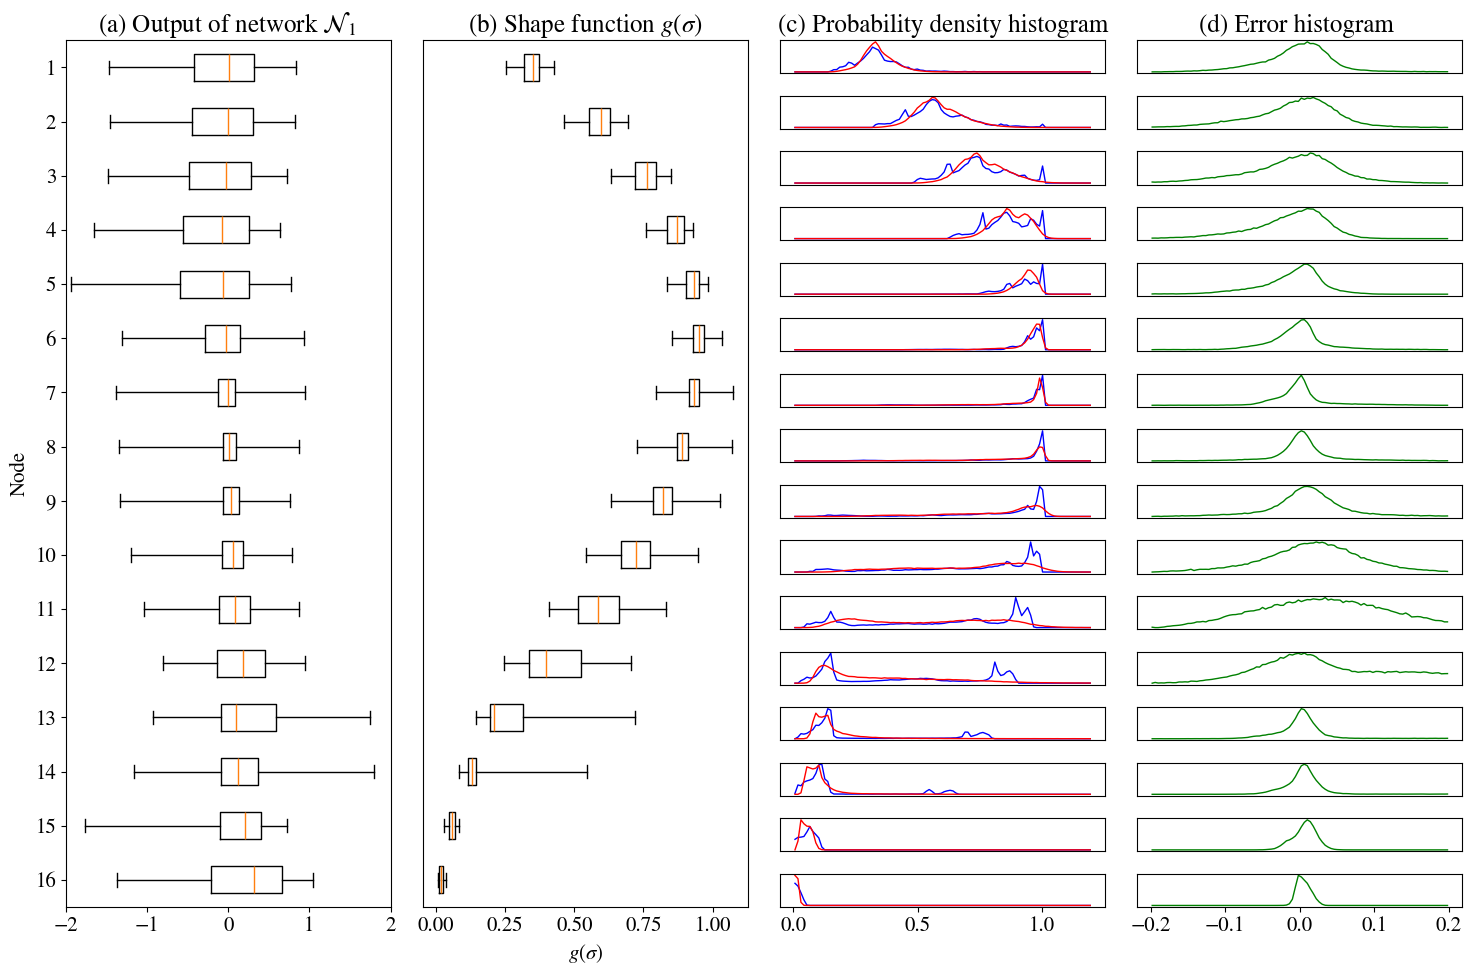

In [17]:
performance_sigma_point(model, x, valid_x, y, valid_y, k_mean, k_std)

## 6.2 Hyperparameter Sweep for Network Architecture

In this section, we conducted a hyperparameter sweep to evaluate the performance of different neural network architectures by varying:
- The **number of layers**.
- The **number of hidden nodes per layer**.

#### Parameter Count Calculation
The number of trainable parameters for a given architecture is calculated as:
$$
P = \sum_{l=1}^{L} \big( n_{\text{input}, l} \times n_{\text{output}, l} + n_{\text{output}, l} \big)
$$
Where:
- $ n_{\text{input}, l} $: Number of input nodes to layer $l $.
- $ n_{\text{output}, l} $: Number of output nodes from layer $ l$.

Using a **4-core CPU with 32GB RAM**, the estimated computational time for training all models with the above configurations is significant without GPU acceleration.

To make the exploration feasible on available resources:
- We limited the sweep to **1-2 layers** and **2-32 hidden nodes** per layer. This enables a quick yet meaningful evaluation of the model's depth and width while keeping computational requirements manageable.

For those interested in exploring more complex architectures: Platforms like **Google Cloud Platform (GCP)** or other systems with **GPU/TPU support** can significantly reduce training time.


In [18]:
## We perform hyper-parmaeters sweep in this section.

epochs, k_points, lr=3000, 16, 1e-03

kms1=1.0 
kms2=100.0 

kmask=np.array([kms1,kms1,kms2,kms2,kms2,kms2,kms2,kms2,kms2,kms1,kms1,kms1,kms1,kms1,kms1,kms1])

hid_array=np.array([2,4,8,16,32])

lays = np.array([1,2])

torch.manual_seed(10)

k_mean_c=torch.tensor(k_mean).float().to(device)
k_std_c=torch.tensor(k_std).float().to(device)

for la in lays:
    cwd_sd = cwd_output + 'ensemble_models_layers' + str(la) + '/'

    for h in hid_array:
        in_nod, hid_nod, o_nod = 4, h, 16
        print('la, h is >', la, h)

        if la == 1:
            model = ff.learnKappa_layers1(in_nod, hid_nod, o_nod)
        elif la == 2:
            model = ff.learnKappa_layers2(in_nod, hid_nod, o_nod)
        elif la == 3:
            model = ff.learnKappa_layers3(in_nod, hid_nod, o_nod)
        elif la == 4:
            model = ff.learnKappa_layers4(in_nod, hid_nod, o_nod)
        else:
            print('Check code')

        model = model.to(device)

        model, loss_array = modeltrain_loss(in_nod, hid_nod, o_nod, lr, epochs, x, y, valid_x, valid_y, model, 
                                            torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)

        directory = os.path.join(cwd_sd, f'mod_dir_{h}')
        os.makedirs(directory, exist_ok=True)

        # Save the model
        model_path = os.path.join(directory, 'model.pt')
        torch.save(model, model_path)

        # Save the loss array
        loss_path = os.path.join(directory, 'loss_array.txt')
        np.savetxt(loss_path, loss_array.detach().numpy())

        # Verify the save
        if os.path.exists(model_path):
            print(f"Model saved successfully: {model_path}")
        else:
            print(f"Failed to save model: {model_path}")

        if os.path.exists(loss_path):
            print(f"Loss array saved successfully: {loss_path}")
        else:
            print(f"Failed to save loss array: {loss_path}")

        del model, loss_array
        torch.cuda.empty_cache()


torch.cuda.empty_cache()

la, h is > 1 2


Training Progress:  30%|██▉       | 899/3000 [00:13<00:30, 68.37epoch/s, patience_count=9, train_loss=0.0715, valid_loss=0.0984]



Early stopping at epoch 899. Validation loss has not improved for 10 epochs.
Model saved successfully: /home/jovyan/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization/output/ensemble_models_layers1/mod_dir_2/model.pt
Loss array saved successfully: /home/jovyan/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization/output/ensemble_models_layers1/mod_dir_2/loss_array.txt
la, h is > 1 4


Training Progress:  25%|██▌       | 760/3000 [00:11<00:33, 66.52epoch/s, patience_count=9, train_loss=0.0663, valid_loss=0.0894]



Early stopping at epoch 760. Validation loss has not improved for 10 epochs.
Model saved successfully: /home/jovyan/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization/output/ensemble_models_layers1/mod_dir_4/model.pt
Loss array saved successfully: /home/jovyan/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization/output/ensemble_models_layers1/mod_dir_4/loss_array.txt
la, h is > 1 8


Training Progress:  26%|██▌       | 779/3000 [00:12<00:35, 63.22epoch/s, patience_count=9, train_loss=0.0591, valid_loss=0.0822]



Early stopping at epoch 779. Validation loss has not improved for 10 epochs.
Model saved successfully: /home/jovyan/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization/output/ensemble_models_layers1/mod_dir_8/model.pt
Loss array saved successfully: /home/jovyan/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization/output/ensemble_models_layers1/mod_dir_8/loss_array.txt
la, h is > 1 16


Training Progress:  20%|██        | 615/3000 [00:11<00:43, 55.24epoch/s, patience_count=9, train_loss=0.0532, valid_loss=0.0749]



Early stopping at epoch 615. Validation loss has not improved for 10 epochs.
Model saved successfully: /home/jovyan/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization/output/ensemble_models_layers1/mod_dir_16/model.pt
Loss array saved successfully: /home/jovyan/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization/output/ensemble_models_layers1/mod_dir_16/loss_array.txt
la, h is > 1 32


Training Progress:  16%|█▌        | 486/3000 [00:11<00:57, 43.48epoch/s, patience_count=9, train_loss=0.0531, valid_loss=0.0755]



Early stopping at epoch 486. Validation loss has not improved for 10 epochs.
Model saved successfully: /home/jovyan/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization/output/ensemble_models_layers1/mod_dir_32/model.pt
Loss array saved successfully: /home/jovyan/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization/output/ensemble_models_layers1/mod_dir_32/loss_array.txt
la, h is > 2 2


Training Progress:  23%|██▎       | 697/3000 [00:11<00:38, 59.54epoch/s, patience_count=9, train_loss=0.0803, valid_loss=0.104]



Early stopping at epoch 697. Validation loss has not improved for 10 epochs.
Model saved successfully: /home/jovyan/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization/output/ensemble_models_layers2/mod_dir_2/model.pt
Loss array saved successfully: /home/jovyan/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization/output/ensemble_models_layers2/mod_dir_2/loss_array.txt
la, h is > 2 4


Training Progress:  27%|██▋       | 806/3000 [00:14<00:38, 56.49epoch/s, patience_count=9, train_loss=0.0706, valid_loss=0.0969]



Early stopping at epoch 806. Validation loss has not improved for 10 epochs.
Model saved successfully: /home/jovyan/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization/output/ensemble_models_layers2/mod_dir_4/model.pt
Loss array saved successfully: /home/jovyan/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization/output/ensemble_models_layers2/mod_dir_4/loss_array.txt
la, h is > 2 8


Training Progress:  17%|█▋        | 510/3000 [00:09<00:47, 52.09epoch/s, patience_count=9, train_loss=0.0613, valid_loss=0.0817]



Early stopping at epoch 510. Validation loss has not improved for 10 epochs.
Model saved successfully: /home/jovyan/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization/output/ensemble_models_layers2/mod_dir_8/model.pt
Loss array saved successfully: /home/jovyan/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization/output/ensemble_models_layers2/mod_dir_8/loss_array.txt
la, h is > 2 16


Training Progress:  21%|██        | 622/3000 [00:14<00:56, 41.74epoch/s, patience_count=9, train_loss=0.0494, valid_loss=0.068] 



Early stopping at epoch 622. Validation loss has not improved for 10 epochs.
Model saved successfully: /home/jovyan/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization/output/ensemble_models_layers2/mod_dir_16/model.pt
Loss array saved successfully: /home/jovyan/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization/output/ensemble_models_layers2/mod_dir_16/loss_array.txt
la, h is > 2 32


Training Progress:  21%|██        | 634/3000 [00:21<01:21, 28.97epoch/s, patience_count=9, train_loss=0.0403, valid_loss=0.0586]



Early stopping at epoch 634. Validation loss has not improved for 10 epochs.
Model saved successfully: /home/jovyan/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization/output/ensemble_models_layers2/mod_dir_32/model.pt
Loss array saved successfully: /home/jovyan/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization/output/ensemble_models_layers2/mod_dir_32/loss_array.txt


In [21]:
## Uncertainty in training 4-32-32-16 model:
ensemble_dir = cwd_output + 'ensemble_models_layers2_uncertainty'
os.makedirs(ensemble_dir, exist_ok=True)

epochs, k_points, lr = 3000, 16, 1e-03
in_nod, hid_nod, o_nod = 4, 32, 16

seeds = np.arange(10, 15)

for seed in seeds:
    print(f"Training with seed {seed}")
    # Define model directory for this seed
    model_dir = os.path.join(ensemble_dir, f'mod_dir_{seed}')
    
    os.makedirs(model_dir, exist_ok=True)

    model = ff.learnKappa_layers2(in_nod, hid_nod, o_nod)  # Update layers as needed
    model = model.to(device)

    # Train the model
    model, loss_array = modeltrain_loss(
        in_nod, hid_nod, o_nod, lr, epochs, x, y, valid_x, valid_y, model,
        torch.tensor(kmask).float().to(device), k_mean_c, k_std_c
    )

    # Save model and loss array for this seed
    torch.save(model, os.path.join(model_dir, 'model.pt'))
    np.savetxt(os.path.join(model_dir, 'loss_array.txt'), loss_array.detach().numpy())


Training with seed 10


Training Progress:  18%|█▊        | 545/3000 [00:18<01:24, 29.10epoch/s, patience_count=9, train_loss=0.0433, valid_loss=0.0622]



Early stopping at epoch 545. Validation loss has not improved for 10 epochs.
Training with seed 11


Training Progress:  20%|█▉        | 588/3000 [00:20<01:22, 29.09epoch/s, patience_count=9, train_loss=0.0427, valid_loss=0.0617]



Early stopping at epoch 588. Validation loss has not improved for 10 epochs.
Training with seed 12


Training Progress:  27%|██▋       | 823/3000 [00:28<01:14, 29.03epoch/s, patience_count=9, train_loss=0.0397, valid_loss=0.058] 



Early stopping at epoch 823. Validation loss has not improved for 10 epochs.
Training with seed 13


Training Progress:  19%|█▊        | 562/3000 [00:19<01:23, 29.03epoch/s, patience_count=9, train_loss=0.0409, valid_loss=0.0589]



Early stopping at epoch 562. Validation loss has not improved for 10 epochs.
Training with seed 14


Training Progress:  22%|██▏       | 663/3000 [00:22<01:20, 29.01epoch/s, patience_count=9, train_loss=0.0414, valid_loss=0.0609]



Early stopping at epoch 663. Validation loss has not improved for 10 epochs.


Scores saved successfully.
Losses saved by seed successfully.


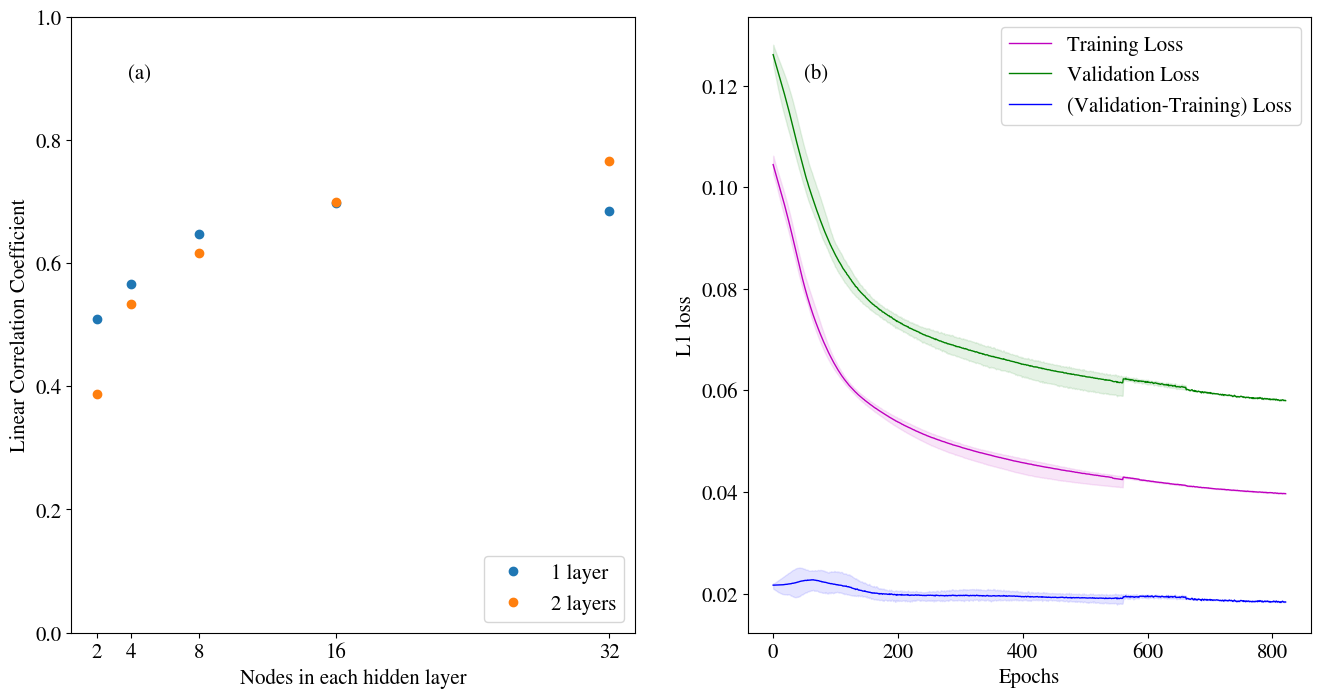

Plot saved successfully.


In [22]:
score_eval(hid_array, lays, valid_x, valid_y, k_mean_c, k_std_c, cwd_output)
save_losses_by_seed(os.path.join(cwd_output, 'ensemble_models_layers2_uncertainty/'), seeds)
plot_n1_scores(cwd_output, hid_array, lays, seeds, epochs=3000)

We estimate uncertainty in our model predictions by training multiple models with different random seeds, capturing variations in initialization and training processes. 
Here, we use 5 random seeds to balance computational efficiency and result reliability. In practice, increasing the number of seeds would provide a more robust estimation of uncertainty, leading to more accurate results.